In [80]:
import rasterio as rio
import earthpy.plot as ep
import pandas as pd
from rasterio.plot import reshape_as_image, reshape_as_raster
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [2]:
with rio.open('raw_data/ESA WorldCover 2020.tif') as src:
    land_cover = src.read()
    profile = src.profile
    src.close()

In [69]:
np.unique(land_cover, return_counts=True)

(array([10, 20, 30, 40, 50, 60, 80, 90], dtype=uint8),
 array([5864110,  302724,   84619,    9973,  116384,  356643,    2687,
            136], dtype=int64))

In [5]:
with rio.open('outputs/ghana_prepped_2020.tif') as src:
    ghana_2020 = src.read()
    profile = src.profile
    src.close()

In [17]:
data = np.vstack([ghana_2020, land_cover])

data

array([[[ 2.27000000e-02,  2.27000000e-02,  2.06000000e-02, ...,
          2.50000000e-02,  2.34500000e-02,  2.34500000e-02],
        [ 1.80000000e-02,  1.80000000e-02,  1.50000000e-02, ...,
          2.65500000e-02,  2.41500000e-02,  2.41500000e-02],
        [ 1.80000000e-02,  1.80000000e-02,  1.50000000e-02, ...,
          2.65500000e-02,  2.41500000e-02,  2.41500000e-02],
        ...,
        [ 1.90000000e-03,  1.90000000e-03,  3.60000000e-03, ...,
          2.92000000e-02,  3.06000000e-02,  3.06000000e-02],
        [ 1.90000000e-03,  1.90000000e-03,  3.60000000e-03, ...,
          2.92000000e-02,  3.06000000e-02,  3.06000000e-02],
        [ 3.00000000e-03,  3.00000000e-03,  3.80000000e-03, ...,
          2.98000000e-02,  2.94000000e-02,  2.94000000e-02]],

       [[ 4.56000000e-02,  4.72000000e-02,  4.51000000e-02, ...,
          4.17000000e-02,  4.41000000e-02,  4.05500000e-02],
        [ 4.44000000e-02,  4.50000000e-02,  3.87000000e-02, ...,
          4.48000000e-02,  4.75500000e

In [20]:
# Separate train and test data geographically
train_set = data[..., 625:]
test_set = data[..., :625]

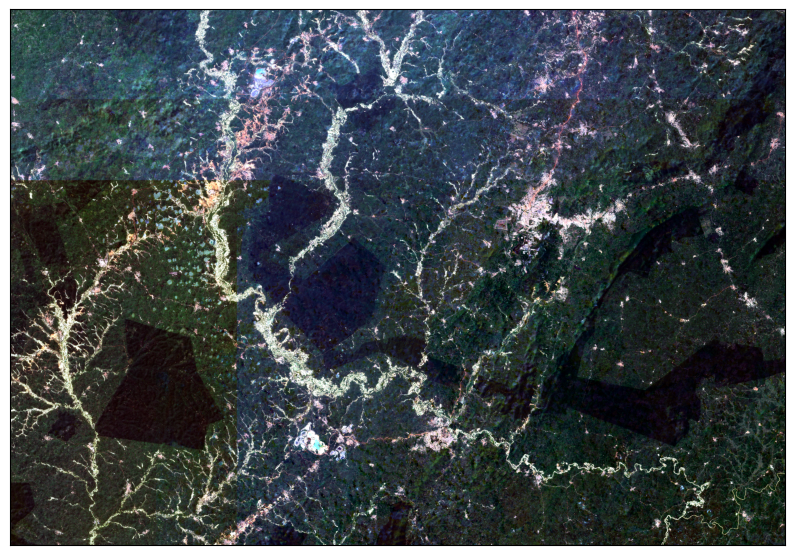

<Axes: >

In [21]:
# Full data
ep.plot_rgb(data, rgb = (3,2,1), stretch = True)

C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\earthpy\spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


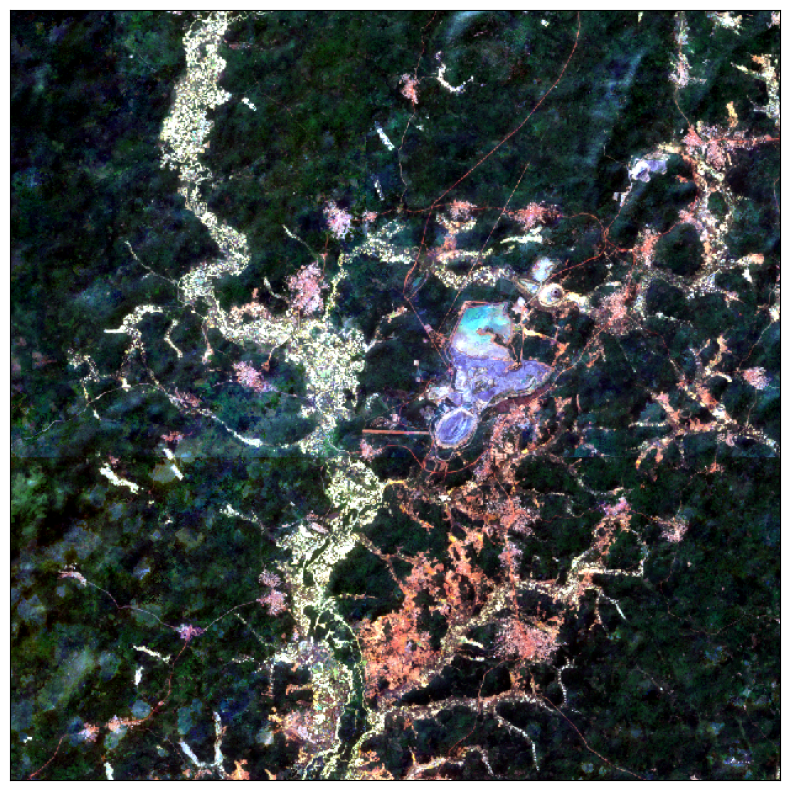

<Axes: >

In [63]:
ep.plot_rgb(train_set[:, :625, :625], rgb = (3,2,1), stretch = True)

In [70]:
train_set.shape

(19, 2158, 2497)

In [71]:
# Select smaller study area
study_area = train_set[:, :625, :625]

# change from band, x, y to x, y, band
# then reshape into z columns, where z is the number of bands
image_array = reshape_as_image(study_area)

# convert all pixels to rows
ml_prep_array = image_array.reshape(-1, study_area.shape[0])

ml_prep_array

array([[ 4.17000000e-02,  3.96000000e-02,  5.37000000e-02, ...,
        -1.60431374e+01,  6.19352830e-01,  1.00000000e+01],
       [ 4.26000000e-02,  4.28000000e-02,  5.89000000e-02, ...,
        -1.50256828e+01,  6.33271181e-01,  1.00000000e+01],
       [ 4.15500000e-02,  4.33000000e-02,  6.35000000e-02, ...,
        -1.57338187e+01,  6.30333815e-01,  1.00000000e+01],
       ...,
       [ 4.95500000e-02,  5.69500000e-02,  8.24500000e-02, ...,
        -1.65856497e+01,  6.21372366e-01,  5.00000000e+01],
       [ 5.06000000e-02,  4.98000000e-02,  7.72000000e-02, ...,
        -1.44283355e+01,  6.18743562e-01,  1.00000000e+01],
       [ 5.06000000e-02,  6.45000000e-02,  8.91000000e-02, ...,
        -1.67921677e+01,  6.16443572e-01,  6.00000000e+01]])

In [72]:
train_data = pd.DataFrame(data = ml_prep_array, 
                          columns = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9",
                                     "B11", "B12", "NDVI", "MNDWI", "BSI", "VV", "VH", "M", "class"])

train_data

B1       B2       B3       B4       B5       B6       B7  \
0       0.04170  0.03960  0.05370  0.04150  0.08130  0.19190  0.22910   
1       0.04260  0.04280  0.05890  0.04210  0.07660  0.20010  0.24680   
2       0.04155  0.04330  0.06350  0.04235  0.08735  0.23255  0.28300   
3       0.04145  0.04605  0.06025  0.04235  0.09245  0.23510  0.28190   
4       0.04145  0.04325  0.05805  0.04080  0.08865  0.23295  0.28995   
...         ...      ...      ...      ...      ...      ...      ...   
390620  0.04490  0.04830  0.06640  0.05770  0.10800  0.20240  0.24760   
390621  0.04840  0.04550  0.06410  0.05710  0.10480  0.19720  0.23370   
390622  0.04955  0.05695  0.08245  0.07715  0.12945  0.20690  0.23805   
390623  0.05060  0.04980  0.07720  0.06370  0.12950  0.22820  0.27260   
390624  0.05060  0.06450  0.08910  0.09430  0.14080  0.18760  0.21620   

             B8      B8A       B9      B11      B12      NDVI     MNDWI  \
0       0.23510  0.26200  0.26280  0.16700  0.08300  0.324104 -0.513367   
1       0.25220  0.27610  0.27720  0.16700  0.08920  0.290649 -0.478530   
2       0.29710  0.30840  0.27810  0.18425  0.09595  0.346955 -0.487386   
3       0.29165  0.31590  0.30850  0.17645  0.09100  0.371662 -0.490917   
4       0.29865  0.31800  0.30850  0.17650  0.08725  0.369641 -0.505010   
...         ...      ...      ...      ...      ...       ...       ...   
390620  0.25250  0.27310  0.26240  0.18500  0.10110  0.303561 -0.471758   
390621  0.25270  0.26720  0.24700  0.18460  0.10340  0.294626 -0.484520   
390622  0.24270  0.26385  0.23885  0.20780  0.12600  0.253146 -0.431869   
390623  0.27630  0.28590  0.22140  0.20040  0.11730  0.340580 -0.443804   
390624  0.22360  0.24310  0.22140  0.22650  0.14530  0.197788 -0.435361   

             BSI         VV         VH         M  class  
0      -0.315381  -9.859929 -16.043137  0.619353   10.0  
1      -0.403549  -8.701408 -15.025683  0.633271   10.0  
2      -0.450805  -9.227271 -15.733819  0.630334   10.0  
3      -0.499086  -7.390610 -14.147544  0.656860   10.0  
4      -0.526340  -6.883329 -13.541492  0.662992   10.0  
...          ...        ...        ...       ...    ...  
390620 -0.246937 -10.602810 -17.841477  0.627243   60.0  
390621 -0.179977  -9.643658 -16.216350  0.627082   60.0  
390622 -0.043323 -10.106316 -16.585650  0.621372   50.0  
390623 -0.248508  -8.890429 -14.428336  0.618744   10.0  
390624  0.166667 -10.448229 -16.792168  0.616444   60.0  

[390625 rows x 19 columns]

In [73]:
# Drop na
train_data_cleaned = train_data.dropna().reset_index(drop = True)

train_data_cleaned

B1       B2       B3       B4       B5       B6       B7  \
0       0.04170  0.03960  0.05370  0.04150  0.08130  0.19190  0.22910   
1       0.04260  0.04280  0.05890  0.04210  0.07660  0.20010  0.24680   
2       0.04155  0.04330  0.06350  0.04235  0.08735  0.23255  0.28300   
3       0.04145  0.04605  0.06025  0.04235  0.09245  0.23510  0.28190   
4       0.04145  0.04325  0.05805  0.04080  0.08865  0.23295  0.28995   
...         ...      ...      ...      ...      ...      ...      ...   
390617  0.04490  0.04830  0.06640  0.05770  0.10800  0.20240  0.24760   
390618  0.04840  0.04550  0.06410  0.05710  0.10480  0.19720  0.23370   
390619  0.04955  0.05695  0.08245  0.07715  0.12945  0.20690  0.23805   
390620  0.05060  0.04980  0.07720  0.06370  0.12950  0.22820  0.27260   
390621  0.05060  0.06450  0.08910  0.09430  0.14080  0.18760  0.21620   

             B8      B8A       B9      B11      B12      NDVI     MNDWI  \
0       0.23510  0.26200  0.26280  0.16700  0.08300  0.324104 -0.513367   
1       0.25220  0.27610  0.27720  0.16700  0.08920  0.290649 -0.478530   
2       0.29710  0.30840  0.27810  0.18425  0.09595  0.346955 -0.487386   
3       0.29165  0.31590  0.30850  0.17645  0.09100  0.371662 -0.490917   
4       0.29865  0.31800  0.30850  0.17650  0.08725  0.369641 -0.505010   
...         ...      ...      ...      ...      ...       ...       ...   
390617  0.25250  0.27310  0.26240  0.18500  0.10110  0.303561 -0.471758   
390618  0.25270  0.26720  0.24700  0.18460  0.10340  0.294626 -0.484520   
390619  0.24270  0.26385  0.23885  0.20780  0.12600  0.253146 -0.431869   
390620  0.27630  0.28590  0.22140  0.20040  0.11730  0.340580 -0.443804   
390621  0.22360  0.24310  0.22140  0.22650  0.14530  0.197788 -0.435361   

             BSI         VV         VH         M  class  
0      -0.315381  -9.859929 -16.043137  0.619353   10.0  
1      -0.403549  -8.701408 -15.025683  0.633271   10.0  
2      -0.450805  -9.227271 -15.733819  0.630334   10.0  
3      -0.499086  -7.390610 -14.147544  0.656860   10.0  
4      -0.526340  -6.883329 -13.541492  0.662992   10.0  
...          ...        ...        ...       ...    ...  
390617 -0.246937 -10.602810 -17.841477  0.627243   60.0  
390618 -0.179977  -9.643658 -16.216350  0.627082   60.0  
390619 -0.043323 -10.106316 -16.585650  0.621372   50.0  
390620 -0.248508  -8.890429 -14.428336  0.618744   10.0  
390621  0.166667 -10.448229 -16.792168  0.616444   60.0  

[390622 rows x 19 columns]

In [75]:
X = train_data_cleaned.drop(columns = "class")
y = train_data_cleaned["class"]

# Make y categorical using label encoder
class_encoder = LabelEncoder().fit(y)
y = class_encoder.transform(y)

In [76]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', DummyClassifier(strategy="stratified"))
])

In [78]:
%%time
from sklearn.model_selection import cross_validate

# Dummy F1 score is approximately 0.143 - should be relatively easy to beat
metrics = pd.DataFrame(cross_validate(pipe, X, y, cv = 10, scoring = "f1_macro"))

display(metrics)

metrics['test_score'].mean()

fit_time  score_time  test_score
0  0.114580    0.013400    0.140246
1  0.119200    0.012000    0.141594
2  0.102443    0.022996    0.140465
3  0.100861    0.012006    0.143598
4  0.097253    0.011931    0.143124
5  0.101873    0.013949    0.144856
6  0.110006    0.014027    0.148442
7  0.108846    0.021643    0.141603
8  0.121419    0.013002    0.143167
9  0.112747    0.013001    0.143846

CPU times: total: 1.34 s
Wall time: 1.34 s


0.14309403414731844

In [79]:
pipe.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('model', DummyClassifier(strategy='stratified'))],
 'verbose': False,
 'scaler': StandardScaler(),
 'model': DummyClassifier(strategy='stratified'),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'model__constant': None,
 'model__random_state': None,
 'model__strategy': 'stratified'}

In [ ]:
# Consider using SGDClassifier with the appropriate value
params = {
    'model': [LogisticRegression(max_iter = 3000), RandomForestClassifier(), SVC(), KNeighborsClassifier()]
}

searcher = GridSearchCV(
    estimator=pipe,
    param_grid=params, 
    cv = 10,
    verbose = 5,
    scoring = 'f1_macro',
    n_jobs = -1
).fit(X, y)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV 1/10] END model=LogisticRegression(max_iter=3000);, score=0.363 total time= 1.1min
[CV 2/10] END model=LogisticRegression(max_iter=3000);, score=0.500 total time= 1.0min
[CV 3/10] END model=LogisticRegression(max_iter=3000);, score=0.483 total time= 1.1min
[CV 4/10] END model=LogisticRegression(max_iter=3000);, score=0.405 total time= 1.2min
[CV 5/10] END model=LogisticRegression(max_iter=3000);, score=0.439 total time= 1.3min
[CV 6/10] END model=LogisticRegression(max_iter=3000);, score=0.378 total time= 1.2min
[CV 7/10] END model=LogisticRegression(max_iter=3000);, score=0.351 total time= 1.2min
[CV 8/10] END model=LogisticRegression(max_iter=3000);, score=0.342 total time= 1.3min
[CV 9/10] END model=LogisticRegression(max_iter=3000);, score=0.349 total time= 1.3min
[CV 10/10] END model=LogisticRegression(max_iter=3000);, score=0.330 total time= 1.2min
[CV 1/10] END ...model=RandomForestClassifier();, score=0.371 total 

In [77]:
X_train = X.sample(frac=0.2)
X_val = X.sample(frac=0.02)

y_train = y[X_train.index]
y_val = y[X_val.index]

C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

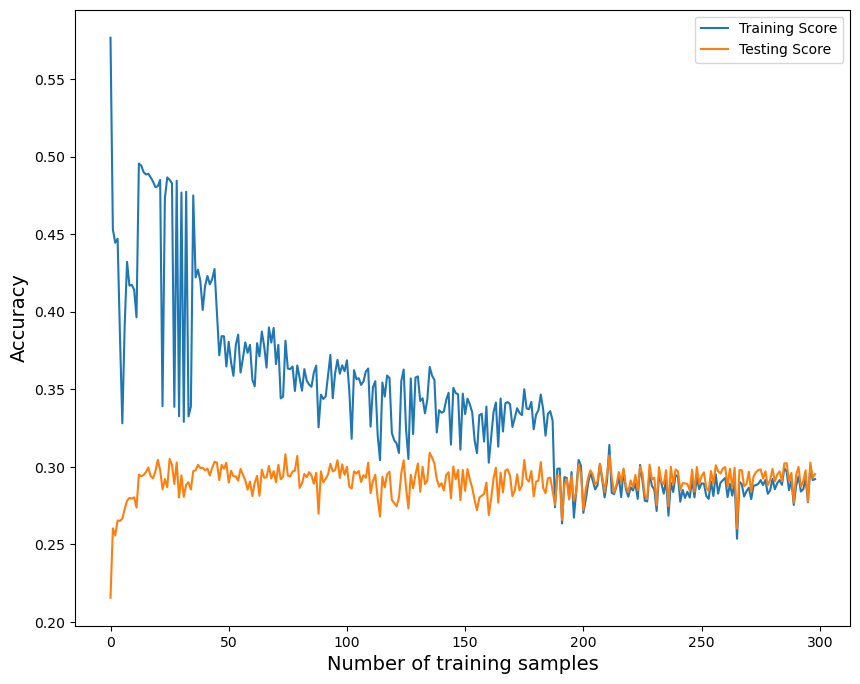

In [59]:
# Learning curve suggests around 20,000 samples needed for analysis

from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

val_score = []
train_score = []

fig, ax = plt.subplots(1,1, figsize=(10,8))
for nb_samples in range(100,30000,100):
    Xi = X_train[:nb_samples]
    yi = y_train[:nb_samples]
    lr = LogisticRegression().fit(Xi, yi)
    y_pred = lr.predict(Xi)
    y_test_pred = lr.predict(X_val)

    train_score.append(f1_score(yi, y_pred, average = 'macro'))
    val_score.append(f1_score(y_val, y_test_pred, average = 'macro'))
                     
ax.plot(train_score, label='Training Score')
ax.plot(val_score, label='Testing Score')
ax.set_xlabel('Number of training samples', size = 14)
ax.set_ylabel('Accuracy', size = 14)
ax.legend();

{'fit_time': array([4.32443714, 3.10663867, 2.79921556, 2.64708376, 2.6173594 ,
        2.60193682, 2.39937997, 2.47037077, 2.61867881, 2.62134242]),
 'score_time': array([0.24406552, 0.23411727, 0.2288661 , 0.23390579, 0.20524693,
        0.20291162, 0.18843293, 0.18309736, 0.24003577, 0.20852923]),
 'test_score': array([0.12520942, 0.12498338, 0.12497397, 0.12473263, 0.12508113,
        0.12498646, 0.12538695, 0.12533975, 0.12531154, 0.12448683])}

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [60]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64),
 array([943399,  36339,  15003,   1895,  20767,  59306,    535,     32],
       dtype=int64))

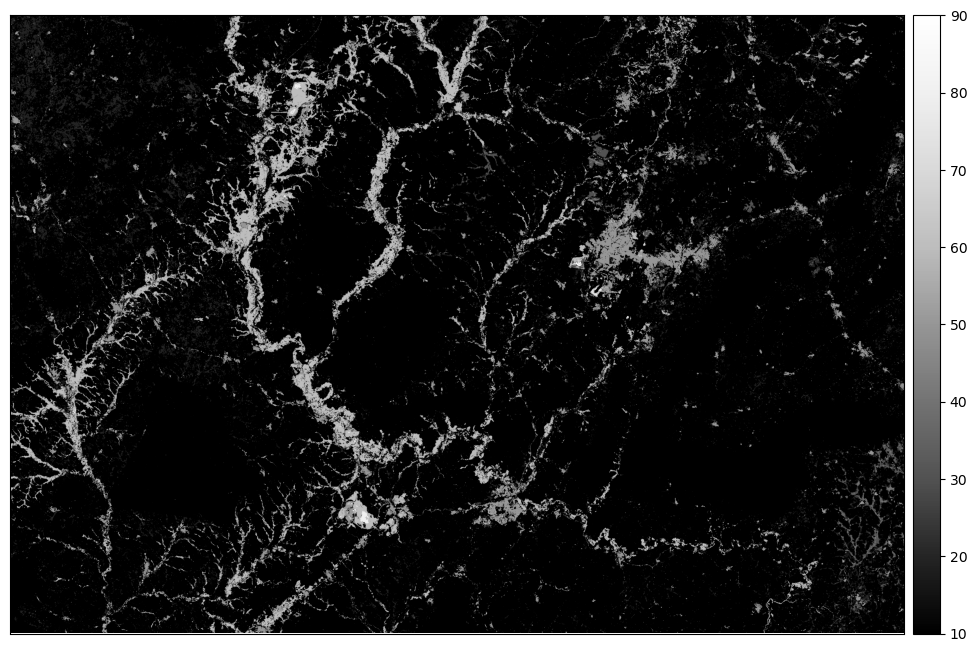

<Axes: >

In [61]:
ep.plot_bands(land_cover)